In [4]:
import functools

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import odc.geo.xr  # noqa
import pydantic
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from shapely.geometry import box

from ocr import catalog, load_structures_destroyed

In [5]:
class ChunkingConfig(pydantic.BaseModel):
    chunks: dict | None = None

    def model_post_init(self, __context):
        self.chunks = self.chunks or dict(zip(['x', 'y'], self.ds.CRPS.data.chunksize))

    def __repr__(self):
        return self.extent.__repr__()

    @functools.cached_property
    def extent(self):
        return box(
            minx=float(self.ds.x.min()),
            maxx=float(self.ds.x.max()),
            miny=float(self.ds.y.min()),
            maxy=float(self.ds.y.max()),
        )

    @functools.cached_property
    def extent_as_tuple(self):
        bounds = self.extent.bounds
        return (bounds[0], bounds[2], bounds[1], bounds[3])

    @functools.cached_property
    def ds(self):
        dataset = (
            catalog.get_dataset('USFS-wildfire-risk-communities')
            .to_xarray()
            .astype('float32')[['CRPS']]
        )
        dataset = dataset.odc.assign_crs('epsg:5070')
        return dataset

    @functools.cached_property
    def transform(self):
        return self.ds.odc.geobox.transform

    @functools.cached_property
    def chunk_info(self):
        """Get information about the dataset's chunks"""
        y_chunks, x_chunks = self.ds.CRPS.data.chunks
        y_starts = np.cumsum([0] + list(y_chunks[:-1]))
        x_starts = np.cumsum([0] + list(x_chunks[:-1]))

        return {
            'y_chunks': y_chunks,
            'x_chunks': x_chunks,
            'y_starts': y_starts,
            'x_starts': x_starts,
        }

    def index_to_coords(self, x_idx, y_idx):
        """Convert array indices to EPSG:5070 coordinates"""
        x, y = self.transform * (x_idx, y_idx)
        return x, y

    def plot_all_chunks(self, color_by_size=False):
        """
        Plot all data chunks across the entire CONUS with their indices as labels

        Parameters
        ----------
        color_by_size : bool, default False
            If True, color chunks based on their size (useful to identify irregularities)
        """
        # Create figure
        fig, ax = plt.subplots(figsize=(16, 12), subplot_kw={'projection': ccrs.AlbersEqualArea()})

        # Set extent to show CONUS
        ax.set_extent(self.extent_as_tuple, crs=ccrs.epsg(5070))

        # Get chunk information
        chunk_info = self.chunk_info
        y_chunks = chunk_info['y_chunks']
        x_chunks = chunk_info['x_chunks']
        y_starts = chunk_info['y_starts']
        x_starts = chunk_info['x_starts']

        # Track chunk sizes for coloring if needed
        if color_by_size:
            sizes = [
                y_chunks[iy] * x_chunks[ix]
                for iy in range(len(y_chunks))
                for ix in range(len(x_chunks))
            ]
            min_size = min(sizes)
            max_size = max(sizes)

            norm = mcolors.Normalize(vmin=min_size, vmax=max_size)
            cmap = cm.viridis

        # Draw each chunk with label
        for iy, y0 in enumerate(y_starts):
            h = y_chunks[iy]
            for ix, x0 in enumerate(x_starts):
                w = x_chunks[ix]

                # Get chunk boundaries in geographic coordinates
                xx0, yy0 = self.index_to_coords(x0, y0)
                xx1, yy1 = self.index_to_coords(x0 + w, y0 + h)

                # Choose color based on size or use default cycle
                if color_by_size:
                    size = h * w
                    color = cmap(norm(size))

                else:
                    # Use a simple coloring scheme based on indices
                    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
                    color = colors[(iy * len(x_starts) + ix) % len(colors)]

                # Draw rectangle around the chunk
                rect = Rectangle(
                    (xx0, yy1),  # lower left (x, y)
                    xx1 - xx0,  # width
                    yy0 - yy1,  # height
                    transform=ccrs.epsg(5070),
                    fill=True,
                    facecolor=color,
                    alpha=0.3,
                    edgecolor=color,
                    linewidth=1.5,
                    zorder=10,
                )
                ax.add_patch(rect)

        # Add geographic features
        ax.coastlines(resolution='10m')
        ax.add_feature(cfeature.BORDERS, linewidth=0.8)
        ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray')

        # Add a colorbar if coloring by size
        if color_by_size:
            sm = cm.ScalarMappable(norm=norm, cmap=cmap)
            cbar = plt.colorbar(sm, ax=ax, shrink=0.6, pad=0.01)
            cbar.set_label('Chunk Size (pixels)')

        # Set title
        ax.set_title(
            f'All Chunks ({len(y_chunks)}×{len(x_chunks)} = {len(y_chunks) * len(x_chunks)})'
        )

        plt.tight_layout()
        plt.show()

    def get_chunks_for_bbox(self, bbox):
        """
        Find all chunks that intersect with the given bounding box

        Parameters
        ----------
        bbox : BoundingBox or tuple
            Bounding box to check for intersection. If tuple, format is (minx, miny, maxx, maxy)

        Returns
        -------
        list of tuples
            List of (iy, ix) tuples identifying the intersecting chunks
        """
        # Convert tuple to BoundingBox if needed
        if isinstance(bbox, tuple):
            if len(bbox) == 4:
                bbox = box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])
            else:
                raise ValueError('Bounding box tuple must have 4 elements (minx, miny, maxx, maxy)')

        # Get chunk info
        chunk_info = self.chunk_info
        y_chunks = chunk_info['y_chunks']
        x_chunks = chunk_info['x_chunks']
        y_starts = chunk_info['y_starts']
        x_starts = chunk_info['x_starts']

        # Find intersecting chunks
        intersecting_chunks = []

        for iy, y0 in enumerate(y_starts):
            h = y_chunks[iy]
            for ix, x0 in enumerate(x_starts):
                w = x_chunks[ix]

                # Get chunk boundaries in geographic coordinates
                xx0, yy0 = self.index_to_coords(x0, y0)
                xx1, yy1 = self.index_to_coords(x0 + w, y0 + h)

                # Create a box for this chunk (note Y axis flip)
                chunk_box = box(xx0, yy1, xx1, yy0)

                # Check for intersection
                if bbox.intersects(chunk_box):
                    intersecting_chunks.append((iy, ix))

        return intersecting_chunks

    def visualize_chunks_on_conus(
        self, chunks=None, color_by_size=False, highlight_chunks=None, include_all_chunks=False
    ):
        """
        Visualize specified chunks on CONUS map

        Parameters
        ----------
        chunks : list of tuples, optional
            List of (iy, ix) tuples specifying chunks to visualize
            If None, will show all chunks
        color_by_size : bool, default False
            If True, color chunks based on their size
        highlight_chunks : list of tuples, optional
            List of (iy, ix) tuples specifying chunks to highlight
        include_all_chunks : bool, default False
            If True, show all chunks in background with low opacity
        """
        # Create figure
        fig, ax = plt.subplots(figsize=(16, 12), subplot_kw={'projection': ccrs.AlbersEqualArea()})

        # Set extent - either full CONUS or custom extent
        ax.set_extent(self.extent_as_tuple, crs=ccrs.epsg(5070))

        # Get chunk information
        chunk_info = self.chunk_info
        y_chunks = chunk_info['y_chunks']
        x_chunks = chunk_info['x_chunks']
        y_starts = chunk_info['y_starts']
        x_starts = chunk_info['x_starts']

        # Set up colors
        if color_by_size:
            sizes = [
                y_chunks[iy] * x_chunks[ix]
                for iy in range(len(y_chunks))
                for ix in range(len(x_chunks))
            ]
            min_size = min(sizes)
            max_size = max(sizes)

            norm = mcolors.Normalize(vmin=min_size, vmax=max_size)
            cmap = cm.viridis

        # Default to all chunks if none specified
        if chunks is None:
            chunks = [(iy, ix) for iy in range(len(y_chunks)) for ix in range(len(x_chunks))]

        # Draw background chunks if requested
        if include_all_chunks and chunks != [
            (iy, ix) for iy in range(len(y_chunks)) for ix in range(len(x_chunks))
        ]:
            for iy, y0 in enumerate(y_starts):
                h = y_chunks[iy]
                for ix, x0 in enumerate(x_starts):
                    # Skip chunks that are in the main visualization
                    if (iy, ix) in chunks:
                        continue

                    w = x_chunks[ix]
                    xx0, yy0 = self.index_to_coords(x0, y0)
                    xx1, yy1 = self.index_to_coords(x0 + w, y0 + h)

                    rect = Rectangle(
                        (xx0, yy1),
                        xx1 - xx0,
                        yy0 - yy1,
                        transform=ccrs.epsg(5070),
                        fill=True,
                        facecolor='lightgray',
                        alpha=0.2,
                        edgecolor='gray',
                        linewidth=0.5,
                        zorder=5,
                    )
                    ax.add_patch(rect)

        # Draw the specified chunks with proper styling
        for iy, ix in chunks:
            y0 = y_starts[iy]
            h = y_chunks[iy]
            x0 = x_starts[ix]
            w = x_chunks[ix]

            # Get chunk boundaries in geographic coordinates
            xx0, yy0 = self.index_to_coords(x0, y0)
            xx1, yy1 = self.index_to_coords(x0 + w, y0 + h)

            # Determine styling
            is_highlighted = highlight_chunks is not None and (iy, ix) in highlight_chunks

            # Choose color based on size or use default cycle
            if is_highlighted:
                color = 'red'
                fill_alpha = 0.4
                linewidth = 2.0
                zorder = 15
            elif color_by_size:
                size = h * w
                color = cmap(norm(size))
                # edge_alpha = 0.8
                fill_alpha = 0.3
                linewidth = 1.5
                zorder = 10
            else:
                # Use a simple coloring scheme based on indices
                colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
                color = colors[(iy * len(x_starts) + ix) % len(colors)]
                fill_alpha = 0.3
                linewidth = 1.5
                zorder = 10

            # Draw rectangle around the chunk
            rect = Rectangle(
                (xx0, yy1),  # lower left (x, y)
                xx1 - xx0,  # width
                yy0 - yy1,  # height
                transform=ccrs.epsg(5070),
                fill=True,
                facecolor=color,
                alpha=fill_alpha,
                edgecolor=color,
                linewidth=linewidth,
                zorder=zorder,
            )
            ax.add_patch(rect)

        # Add geographic features
        ax.coastlines(resolution='10m')
        ax.add_feature(cfeature.BORDERS, linewidth=0.8)
        ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray')

        # Add a colorbar if coloring by size
        if color_by_size:
            sm = cm.ScalarMappable(norm=norm, cmap=cmap)
            cbar = plt.colorbar(sm, ax=ax, shrink=0.6, pad=0.01)
            cbar.set_label('Chunk Size (pixels)')

        # Set title
        if len(chunks) == len(y_chunks) * len(x_chunks):
            ax.set_title(f'All Chunks ({len(y_chunks)}×{len(x_chunks)} = {len(chunks)})')
        else:
            ax.set_title(
                f'Selected Chunks ({len(chunks)} of {len(y_chunks)}×{len(x_chunks)} total)'
            )

        # Add a legend
        legend_elements = [Line2D([0], [0], color='blue', lw=2, label='Selected Chunks')]
        if highlight_chunks:
            legend_elements.append(Line2D([0], [0], color='red', lw=2, label='Highlighted Chunks'))
        if include_all_chunks:
            legend_elements.append(Line2D([0], [0], color='gray', lw=1, label='Other Chunks'))

        ax.legend(handles=legend_elements, loc='lower right')

        plt.tight_layout()
        plt.show()

In [6]:
config = ChunkingConfig()
config

<POLYGON ((2327640 221280, 2327640 3267390, -2362380 3267390, -2362380 22128...>

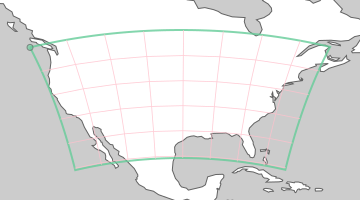

In [7]:
config.ds.odc.geobox

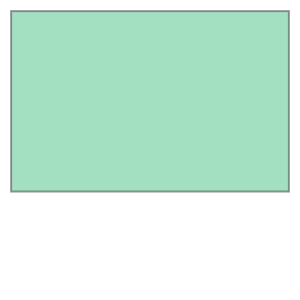

In [8]:
config.extent

In [9]:
config.extent.bounds

(-2362380.000000001, 221280.00000000373, 2327639.999999999, 3267390.0000000037)

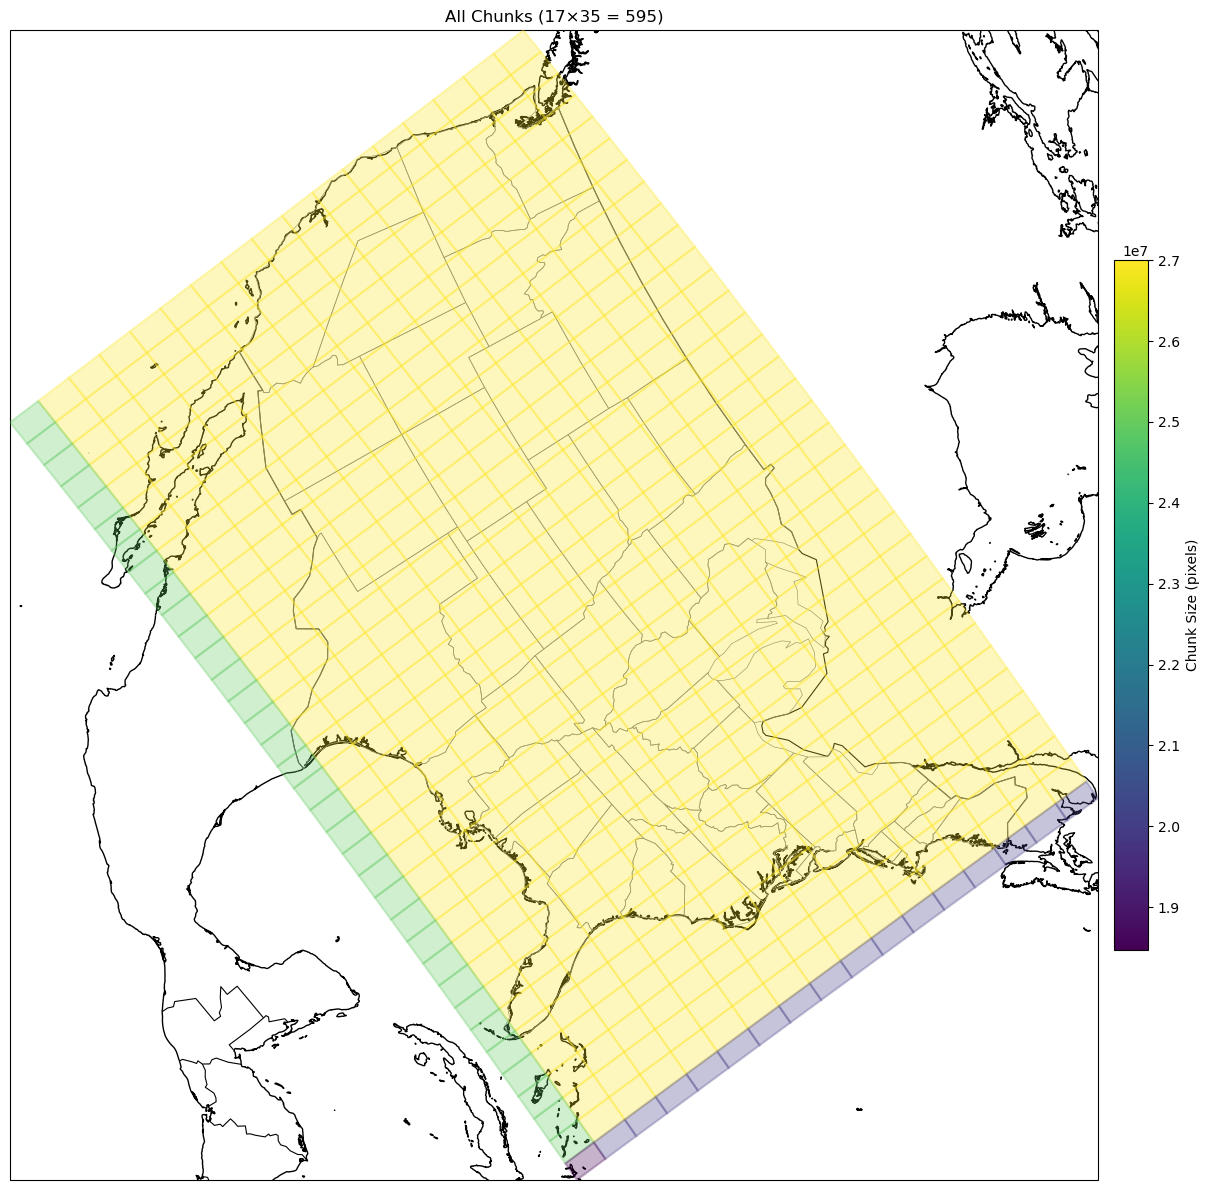

In [10]:
config.plot_all_chunks(color_by_size=True)

In [11]:
bbox = box(-2361645.0000000005, 1744905.0000000023, -1189770.0000000005, 2505780.000000002)
chunks = config.get_chunks_for_bbox(bbox)
len(chunks)

45

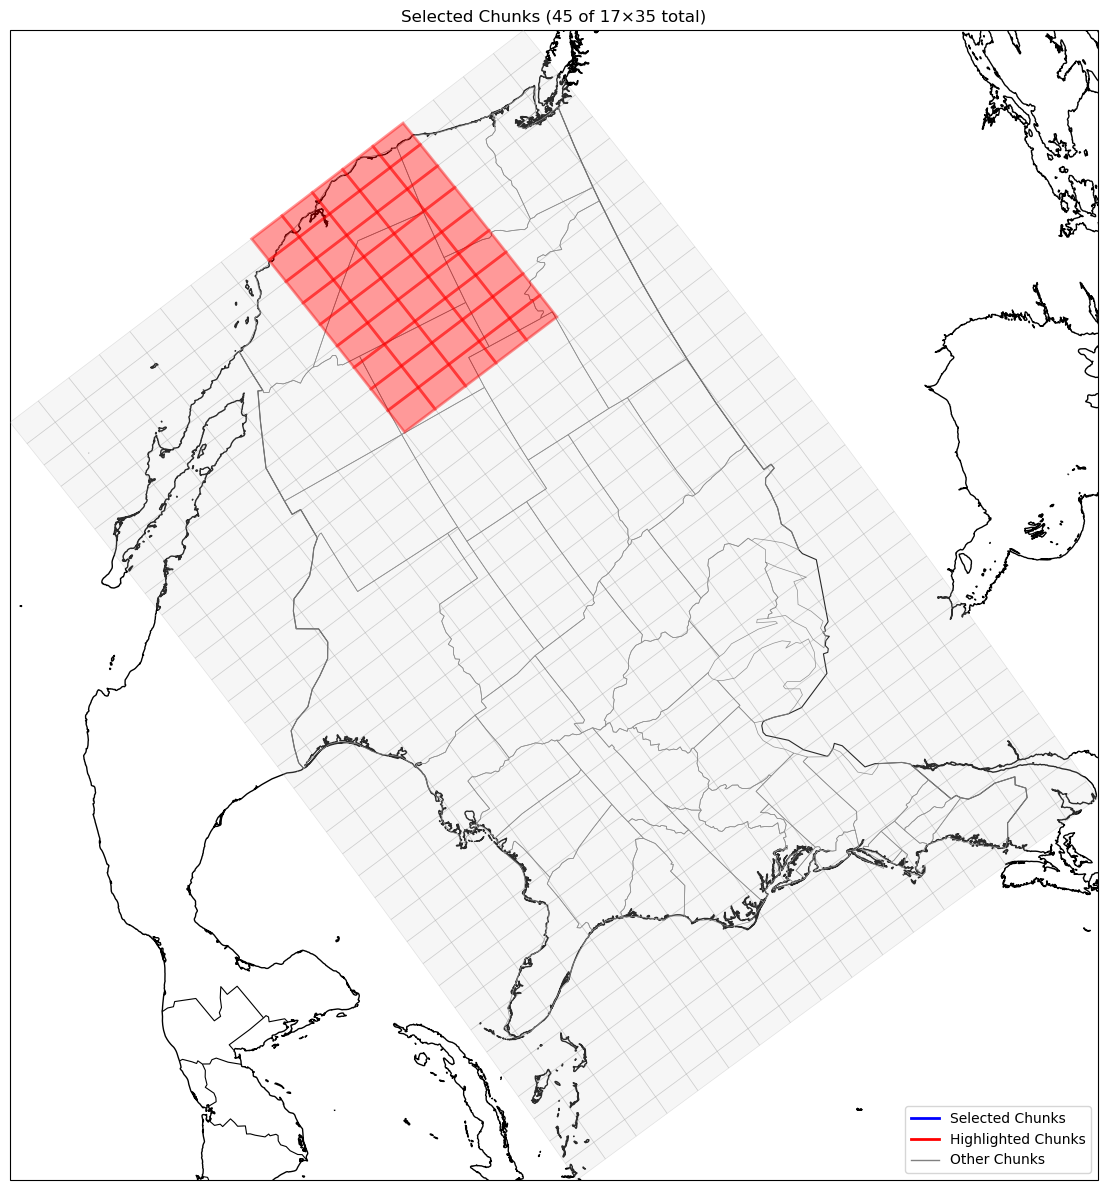

In [12]:
config.visualize_chunks_on_conus(chunks=chunks, include_all_chunks=True, highlight_chunks=chunks)

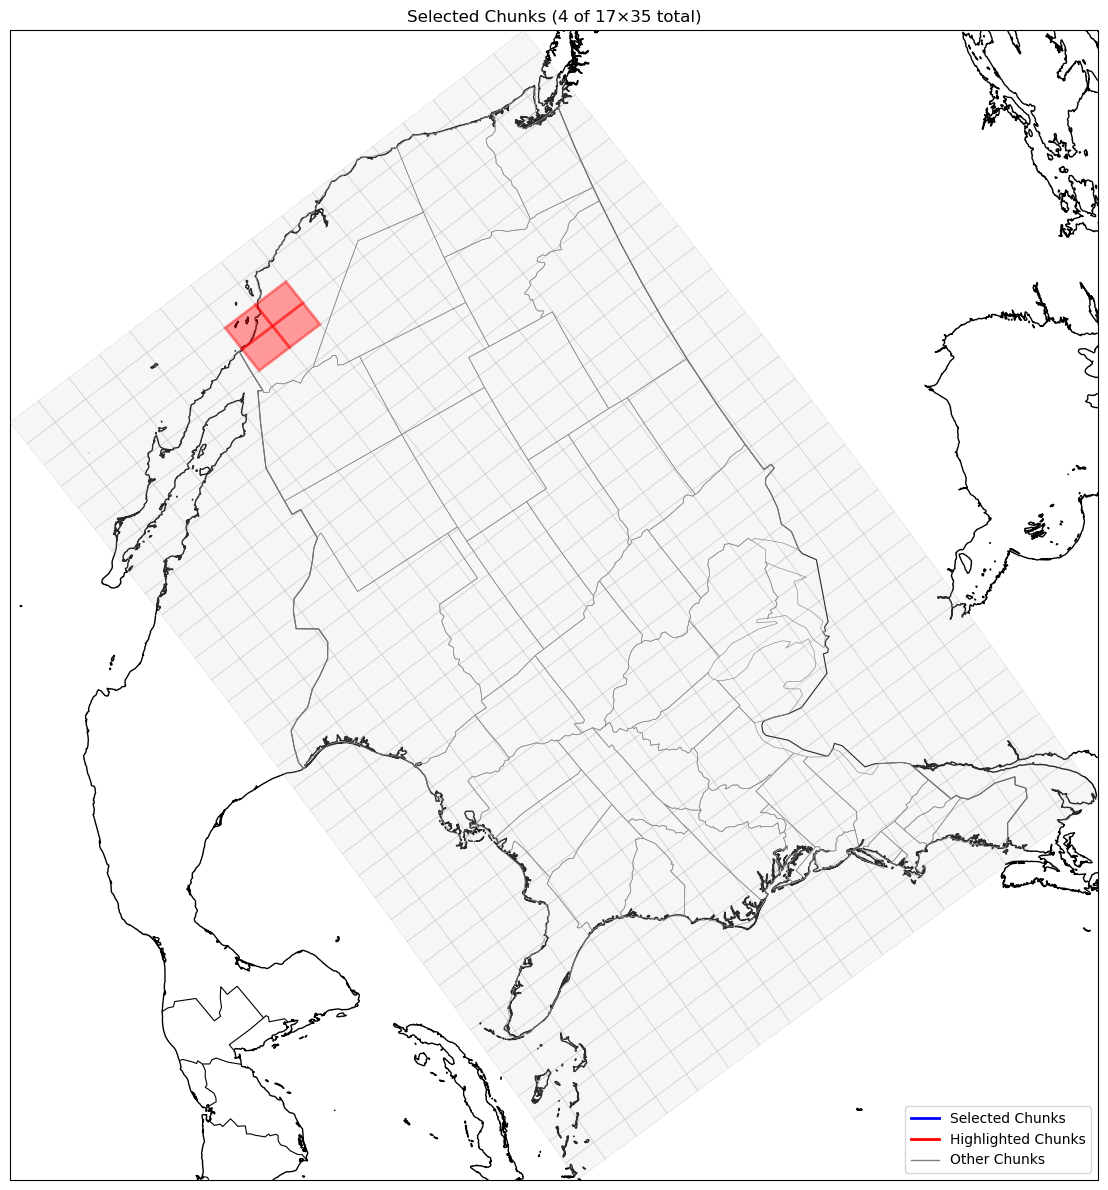

In [13]:
structures = load_structures_destroyed(fire_name='Eaton', target_crs='EPSG:5070')

buffer = 50000
x_min, x_max = structures.geometry.x.min() - buffer, structures.geometry.x.max() + buffer
y_min, y_max = structures.geometry.y.min() - buffer, structures.geometry.y.max() + buffer

bbox = (x_min, y_min, x_max, y_max)
chunks = config.get_chunks_for_bbox(bbox)
config.visualize_chunks_on_conus(chunks=chunks, include_all_chunks=True, highlight_chunks=chunks)

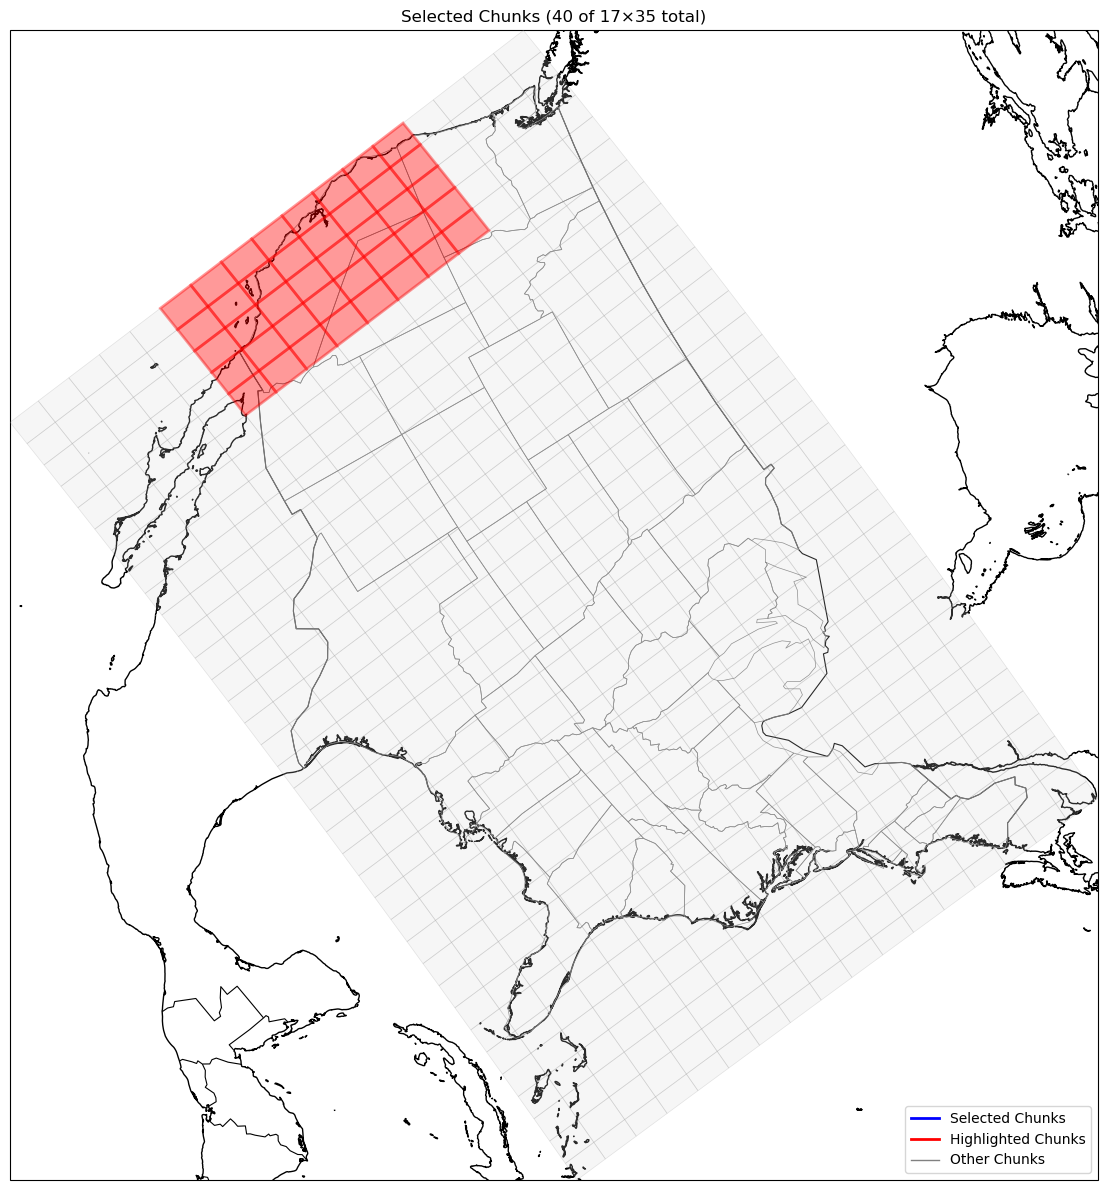

In [14]:
dataset = catalog.get_dataset('cal-fire-damage-inspection')
all_cal_fire = dataset.to_geopandas(
    "SELECT geometry FROM read_parquet('{s3_path}')", target_crs='EPSG:5070'
)

buffer = 50000

x_min, x_max = all_cal_fire.geometry.x.min() - buffer, all_cal_fire.geometry.x.max() + buffer
y_min, y_max = all_cal_fire.geometry.y.min() - buffer, all_cal_fire.geometry.y.max() + buffer

bbox = (x_min, y_min, x_max, y_max)
chunks = config.get_chunks_for_bbox(bbox)
config.visualize_chunks_on_conus(chunks=chunks, include_all_chunks=True, highlight_chunks=chunks)